# Getting started with XGI

XGI is a Python library to make working with and analyzing complex systems with higher-order interactions easy. We have collected a lot of useful functions, algorithms, and tools for working with hypergraphs and simplicial complexes to make life easier.

We will
1. Create and load hypergraphs
2. Convert to different hypergraph representations
2. Visualize hypergraphs and simplicial complexes
3. Show how to use the stats interface
4. Give an example of how to compare an empirical dataset to a null model.

We start off by loading the XGI library.

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import xgi
from IPython.display import display
from matplotlib.pyplot import cm

In [4]:
xgi.__version__

'0.5.6'

### Creating a hypergraph

We want to start with a hypergraph, and this can be done in several ways:
1. Build a hypergraph node-by-node and edge-by-edge (less common, but can be helpful in writing your own generative models)
2. Load an existing dataset
3. Generate from an existing higher-order model

Let's start with the first method.

#### Building a hypergraph

In [ ]:
H_build = xgi.Hypergraph()
H_build.add_edge([1, 2], idx="a")
H_build.add_node(0)
H_build.add_edges_from([[3, 4], [0, 2, 3]])
H_build.add_nodes_from([9, 10])

XGI automatically assigns unique edge IDs (if a user doesn't specify the ID)

In [6]:
H_build.edges

EdgeView(('a', 0, 1))

Why NodeViews and EdgeViews? These allow users to access many different properties and data structures from nodes and edges in a much simpler way. We will cover this more in depth later. For now, we can get the edges of which each node is a part and the nodes in each edge as follows:

In [7]:
print(H_build.nodes.memberships())
print(H_build.edges.members())
print(H_build.nodes.memberships(2))
print(H_build.edges.members("a"))

{1: {'a'}, 2: {1, 'a'}, 0: {1}, 3: {0, 1}, 4: {0}, 9: set(), 10: set()}
[{1, 2}, {3, 4}, {0, 2, 3}]
{1, 'a'}
{1, 2}


#### Loading datasets

Moving on to method 2, one can load datasets in several different ways. First, we provide a companion data repository, [xgi-data](https://gitlab.com/complexgroupinteractions/xgi-data), where users can easily load several datasets in standard format:

In [8]:
H_enron = xgi.load_xgi_data("email-enron")

This dataset, for example, has a corresponding [datasheet](https://gitlab.com/complexgroupinteractions/xgi-data-email-enron/-/blob/main/README.md) explaining its characteristics. The nodes (individuals) in this dataset contain associated email addresses and the edges (emails) contain associated timestamps. These attributes can be accessed by simply typing `H.nodes[id]` or `H.edges[id]` respectively.

In [9]:
print(f"The hypergraph has {H_enron.num_nodes} nodes and {H_enron.num_edges} edges")

The hypergraph has 148 nodes and 10885 edges


In [10]:
print("The first 10 node IDs are:")
print(list(H_enron.nodes)[:10])
print("\nThe first 10 edge IDs are:")
print(list(H_enron.edges)[:10])
print("\nThe attributes of node '4' are")
print(H_enron.nodes["4"])
print("\nThe attributes of edge '6' are")
print(H_enron.edges["6"])

The first 10 node IDs are:
['4', '1', '117', '129', '51', '41', '65', '107', '122', '29']

The first 10 edge IDs are:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

The attributes of node '4' are
{'name': 'robert.badeer@enron.com'}

The attributes of edge '6' are
{'timestamp': '2000-02-22T08:07:00'}


We can clean up this dataset to remove isolates, multi-edges, singletons, and to replace all IDs with integer IDs.

In [11]:
H_enron_cleaned = H_enron.cleanup(in_place=False)

print(
    f"The hypergraph has {H_enron_cleaned.num_nodes} nodes and {H_enron_cleaned.num_edges} edges"
)

print("The first 10 node IDs are:")
print(list(H_enron_cleaned.nodes)[:10])

The hypergraph has 143 nodes and 1514 edges
The first 10 node IDs are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Likewise, one can load from a file. In the `readwrite` module, there are functions for handling a variety of file formats. We may also be interested in the *dual* hypergraph formed by considering nodes to be emails and edges to be email addresses:

#### Random null models

Lastly, we can create  synthetic hypergraphs using random generative models. For example, we can extract the degree and edge size sequence from this dataset and wire them together at random (according to the Chung-Lu model) to create a random null model:

In [36]:
D = H_enron_cleaned.dual()
k = D.nodes.degree.asdict()
s = D.edges.size.asdict()

H_random = xgi.chung_lu_hypergraph(k, s)

We check whether this new hypergraph is connected and if not, the sizes of the connected components:

In [37]:
connected = xgi.is_connected(H_random)
if not connected:
    size, num = np.unique(
        [len(cc) for cc in xgi.connected_components(H_random)], return_counts=True
    )
    print(f"The connected components:")
    display(pd.DataFrame([size, num], columns=["Component size", "Number"]))
else:
    print("The hypergraph is connected!")

The connected components:


,Component size,Number
0,1,1365
1,149,1


We can do much more such as computing different properties, reading/writing, converting to/from different data structures, hypergraph null models and much more!

See the Read The Docs for more information: https://xgi.readthedocs.io

### Converting between different representations

#### Incidence matrix

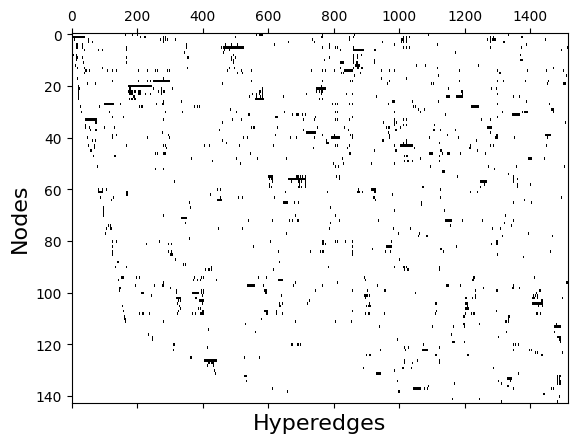

In [14]:
I = xgi.incidence_matrix(H_enron_cleaned, sparse=False)
plt.spy(I, aspect="auto")
plt.xlabel("Hyperedges", fontsize=16)
plt.ylabel("Nodes", fontsize=16)
plt.show()

#### Bipartite network

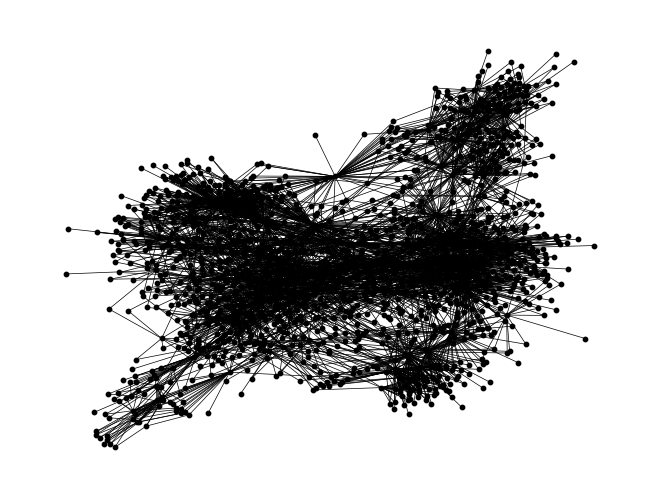

In [15]:
G, index1, index2 = xgi.to_bipartite_graph(H_enron_cleaned)
nx.draw(G, node_color="black", node_size=10, width=0.5)

#### Adjacency matrix

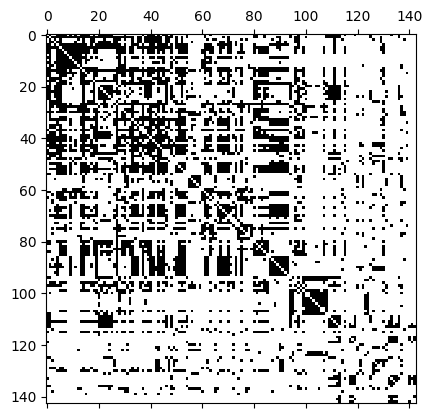

In [16]:
A = xgi.adjacency_matrix(H_enron_cleaned, sparse=False)
plt.spy(A)

#### Line graph

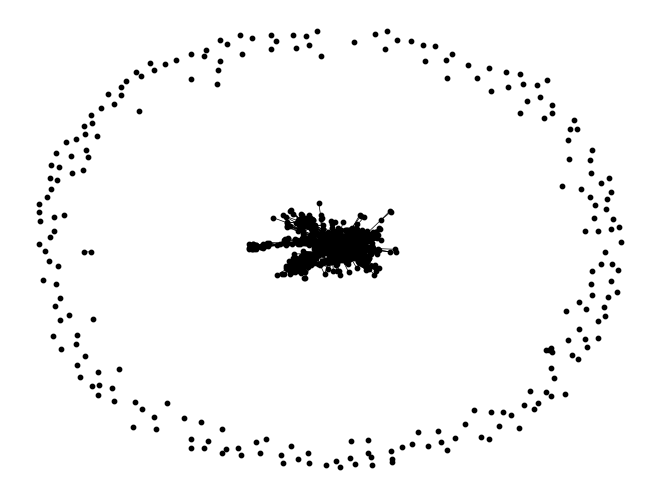

In [18]:
G = xgi.to_line_graph(H_enron_cleaned, s=2)
nx.draw(G, node_color="black", node_size=10, width=0.5)

#### The dual

In [19]:
D = H_enron_cleaned.dual()
print(f"The hypergraph has {D.num_nodes} nodes and {D.num_edges} edges")

The hypergraph has 1514 nodes and 143 edges


### Visualization

The first step for drawing a hypergraph is to choose a layout for the nodes. At the moment the available layouts are:
* ```random_layout```: positions nodes uniformly at random in the unit square.
* ```pairwise_spring_layout```: positions the nodes using the Fruchterman-Reingold force-directed algorithm on the projected graph.
* ```barycenter_spring_layout``` and ```weighted_barycenter_spring_layout```: slight modification of ```pairwise_spring_layout```
    
Each layout returns a dictionary that maps nodes ID into (x, y) coordinates.

In [ ]:
seed = 0
H_viz = xgi.fast_random_hypergraph(20, [0.08, 0.01, 0.001], seed=seed)
pos1 = xgi.pairwise_spring_layout(H_viz, seed=0)

<AxesSubplot: >

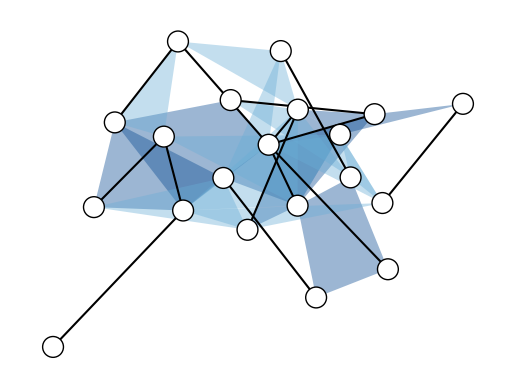

In [21]:
xgi.draw(H_viz, pos1)

Drawing parameters are extremely flexible:

<AxesSubplot: >

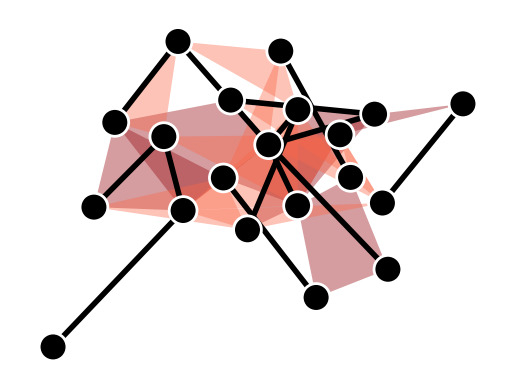

In [22]:
cmap = cm.Reds
dyad_lc = "gray"
dyad_lw = 4
node_fc = "black"
node_ec = "white"
node_lw = 2
node_size = 20

xgi.draw(
    H_viz,
    pos1,
    edge_fc_cmap=cmap,
    dyad_lc=dyad_lc,
    dyad_lw=dyad_lw,
    node_fc=node_fc,
    node_ec=node_ec,
    node_lw=node_lw,
    node_size=node_size,
)

We can even color/draw the nodes and edges based on statistics!

In [ ]:
n = 100
is_connected = False
while not is_connected:
    H = xgi.fast_random_hypergraph(n, [0.03, 0.0002, 0.00001])
    is_connected = xgi.is_connected(H)
pos = xgi.barycenter_spring_layout(H, seed=0)

<AxesSubplot: >

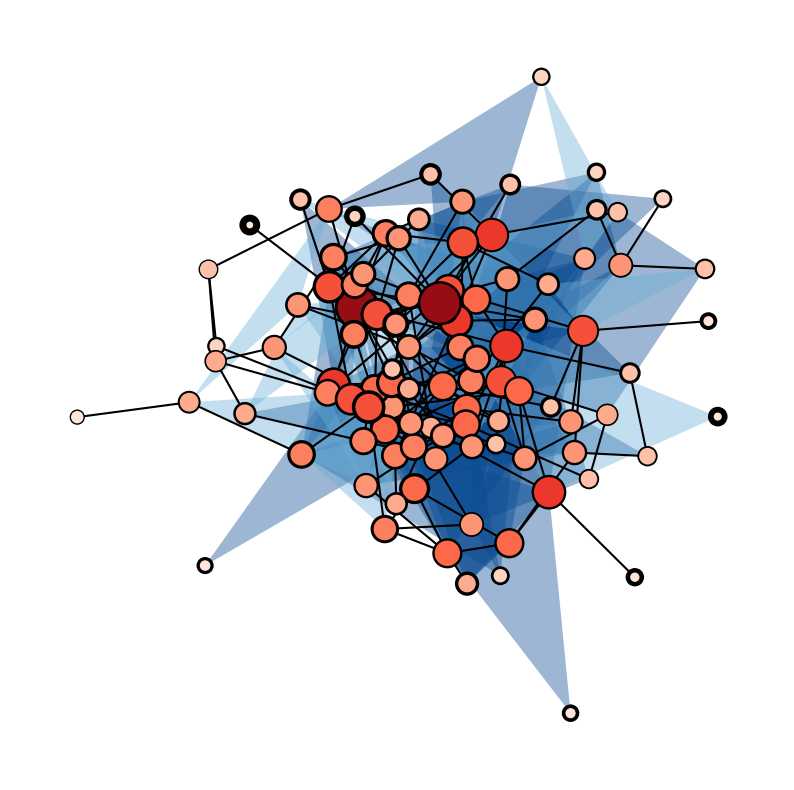

In [24]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
xgi.draw(
    H,
    pos,
    node_size=H.nodes.degree,
    node_lw=H.nodes.average_neighbor_degree,
    node_fc=H.nodes.degree,
    ax=ax,
)

### The stats package

The stats package is one of the features that sets `xgi` apart from other libraries.  It
provides a common interface to all statistics that can be computed from a network, its
nodes, or edges.

Consider the degree of the nodes of a hypergraph `H`.  After computing the values of the
degrees, one may wish to store them in a dict, a list, an array, a dataframe, etc.
Through the stats package, `xgi` provides a simple interface that seamlessly allows for
this type conversion.  This is done via the `NodeStat` class.

In [25]:
H_stats = xgi.Hypergraph([[1, 2, 3], [2, 3, 4, 5], [3, 4, 5]])
H_stats.degree()

{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

In [26]:
H_stats.nodes.degree

NodeStat('degree')

This `NodeStat` object allows us to choose the datatype, specify keywords, and get basic statistics from these properties

In [27]:
print("As a dictionary:")
print(H_stats.nodes.degree.asdict())
print("\nAs a list:")
print(H_stats.nodes.degree.aslist())
print("\nAs a numpy array:")
print(H_stats.nodes.degree.asnumpy())
print("\nAs a pandas dataframe:")
print(H_stats.nodes.degree.aspandas())

As a dictionary:
{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

As a list:
[1, 2, 3, 2, 2]

As a numpy array:
[1 2 3 2 2]

As a pandas dataframe:
1    1
2    2
3    3
4    2
5    2
Name: degree, dtype: int64


In [28]:
print(H_stats.nodes.degree(order=2).asdict())

{1: 1, 2: 1, 3: 2, 4: 1, 5: 1}


In [29]:
st = H_stats.nodes.degree
np.round([st.max(), st.min(), st.mean(), st.median(), st.var(), st.std()], 3)

array([3.   , 1.   , 2.   , 2.   , 0.4  , 0.632])

The interface for attributes is very similar. If we add nodal attributes, for example

In [30]:
H_stats.add_nodes_from(
    [
        (1, {"color": "red", "name": "horse"}),
        (2, {"color": "blue", "name": "pony"}),
        (3, {"color": "yellow", "name": "zebra"}),
        (4, {"color": "red", "name": "orangutan", "age": 20}),
        (5, {"color": "blue", "name": "fish", "age": 2}),
    ]
)
print(H_stats.nodes.attrs("color").asdict())

{1: 'red', 2: 'blue', 3: 'yellow', 4: 'red', 5: 'blue'}


In [31]:
print(H_stats.nodes.attrs[1])

{'color': 'red', 'name': 'horse'}


One can also filter nodes and edges by their attributes as well as any associated statistic. For example,

In [32]:
print(H_stats.nodes.filterby("degree", 2))
print(H_stats.nodes.filterby_attr("color", "blue"))

[2, 4, 5]
[2, 5]


## An example

Let's compare the assortativity of an empirical dataset (Let's choose the `email-enron` dataset) to a random null model. We start by loading the Enron dataset and constructing a Chung-Lu hypergraph using the dataset's degree sequence and edge size sequence:

In [33]:
H = H_enron
k = H.nodes.degree.asdict()
s = H.edges.size.asdict()

H_null = xgi.chung_lu_hypergraph(k, s)

Now we use the definitions of assortativity in "Configuration models of random hypergraphs" by Phil Chodrow to compare the assortativity of the random null model to the original dataset.

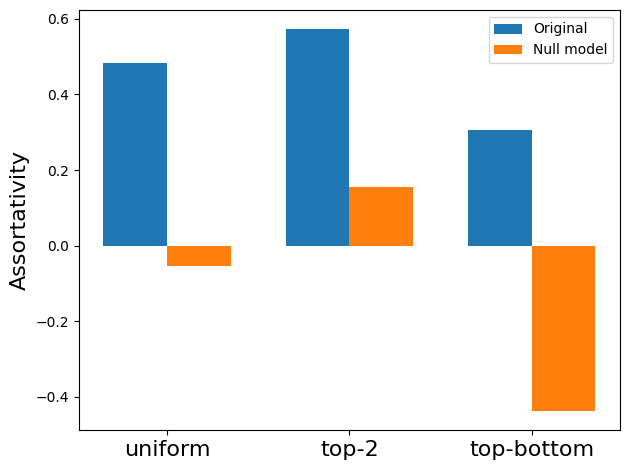

In [34]:
labels = ["uniform", "top-2", "top-bottom"]

assort_orig = []
assort_null = []
for l in labels:
    assort_orig.append(xgi.degree_assortativity(H, kind=l))
    assort_null.append(xgi.degree_assortativity(H_null, kind=l))

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, assort_orig, width, label="Original")
rects2 = ax.bar(x + width / 2, assort_null, width, label="Null model")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.set_ylabel("Assortativity", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

From this plot we can see that the original dataset is more assortative than the random null model.

# For more details, visit https://xgi.readthedocs.io